In [3]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found")

In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

(16338, 128, 128, 7)
Dataset contains 16338 images with 7 channels each, of size 128x128.


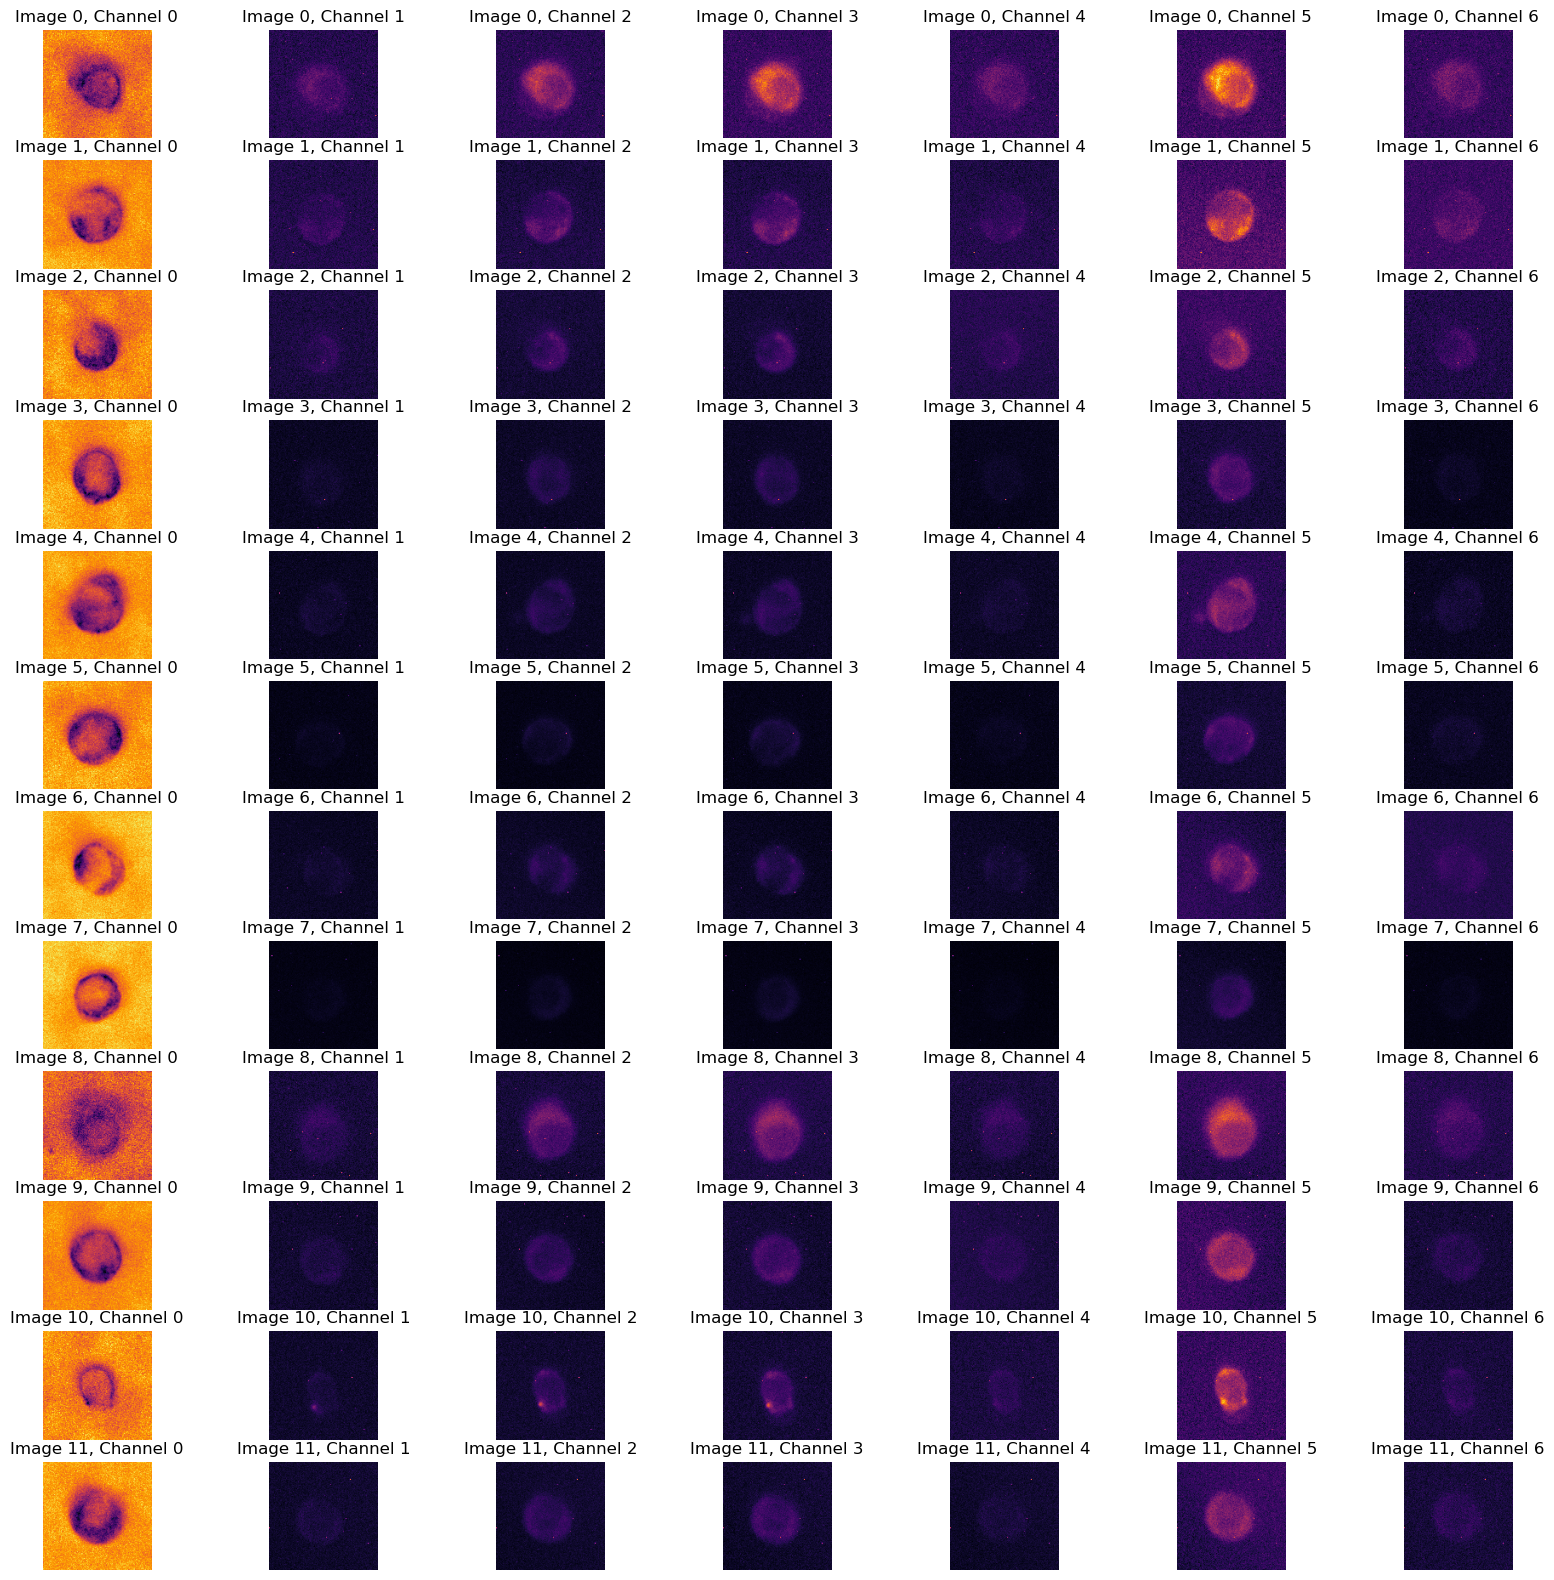

In [5]:
def display_transposedimages_from_hdf5(file_path, num_images_to_display=12):
    with h5py.File(file_path, 'r') as f:
        # Access the dataset
        images_dataset = f['images']
        num_images, height, width, num_channels = images_dataset.shape
        print(images_dataset.shape)
        
        print(f"Dataset contains {num_images} images with {num_channels} channels each, of size {height}x{width}.")

        # Display the first few images
        
        plt.figure(figsize=(20, 20))
        for i in range(min(num_images_to_display, num_images)):
            for j in range(images_dataset.shape[-1]):  # Loop over channels in NHWC format
                img = images_dataset[i, :, :, j]
                plt.subplot(num_images_to_display, images_dataset.shape[-1], i * images_dataset.shape[-1] + j + 1)
                plt.imshow(img, cmap='inferno')
                plt.title(f'Image {i}, Channel {j}')
                plt.axis('off')
            
        plt.show()
        return images_dataset
 
output_file_path = 'fluor_images_transposed.h5'
images_dataset_transposed = display_transposedimages_from_hdf5(output_file_path)


In [6]:
from keras import backend as K
K.set_image_data_format('channels_last')

**PatchGAN Discriminator**

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, LeakyReLU, Activation, Concatenate, BatchNormalization, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal

def define_discriminator(input_shape_2d, output_shape_3d):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    # source image input (2D brightfield)
    in_src_image = Input(shape=input_shape_2d)
    
    # target image input (3D fluorescence)
    in_target_image = Input(shape=output_shape_3d)
    
    # Expand dimensions of source image to match target image
    #expanded_src = Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                          #output_shape=lambda input_shape: input_shape + (1,))(in_src_image)

    
    # Expand dimensions of source image to match target image
    expanded_src = Lambda(lambda x: tf.expand_dims(x, axis=-1),
                          output_shape=lambda input_shape: input_shape + (1,))(in_src_image)

    expanded_src = Lambda(lambda x: tf.tile(x, [1, 1, 1, 1, output_shape_3d[-1]]),
                          output_shape=lambda input_shape: input_shape[:-1] + (output_shape_3d[-1],))(expanded_src)

    expanded_src = Reshape((input_shape_2d[0], input_shape_2d[1], output_shape_3d[-1]))(expanded_src)

    # concatenate images channel-wise
    merged = Concatenate(axis=-1)([expanded_src, in_target_image])
    
    # Reshape merged tensor to 5D for Conv3D
    merged = Reshape((128, 128, output_shape_3d[-1] * 2, 1))(merged)
    
    # C64
    d = Conv3D(64, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C128
    d = Conv3D(128, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C256
    d = Conv3D(256, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C512
    d = Conv3D(512, (4,4,4), strides=(2,2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # second last output layer
    d = Conv3D(512, (4,4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # patch output
    d = Conv3D(1, (4,4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return model

# define image shapes
input_shape_2d = (128, 128, 1)  # 2D brightfield image
output_shape_3d = (128, 128, 6)  # 3D fluorescence image with 6 channels

# create the model
model = define_discriminator(input_shape_2d, output_shape_3d)

# summarize the model
model.summary()


2024-08-07 01:55:34.547820: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-08-07 01:55:34.547837: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-08-07 01:55:34.547841: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-08-07 01:55:34.547856: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-07 01:55:34.547866: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/anagharamadas/anaconda3/envs/GPU/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope`

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 1, 1)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128, 128,  │          0 │ lambda[0][0]      │
│                     │ 1, 6)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 128, 128,  │          0 │ lambda_1[0][0]    │
│                     │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ reshape[0][0],    │
│ (Concatenate)       │ 12)               │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 128, 128,  │          0 │ concatenate[0][0] │
│                     │ 12, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 64, 64, 6, │      4,160 │ reshape_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 64, 64, 6, │          0 │ conv3d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 32, 32, 3, │    524,416 │ leaky_re_lu[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32, 3, │        512 │ conv3d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 32, 32, 3, │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 16, 16, 2, │  2,097,408 │ leaky_re_lu_1[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16, 2, │      1,024 │ conv3d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 16, 16, 2, │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 8, 8, 1,   │  8,389,120 │ leaky_re_lu_2[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 1,   │      2,048 │ conv3d_3[0][0]  

 Total params: 27,831,233 (106.17 MB)

 Trainable params: 27,828,417 (106.16 MB)

 Non-trainable params: 2,816 (11.00 KB)

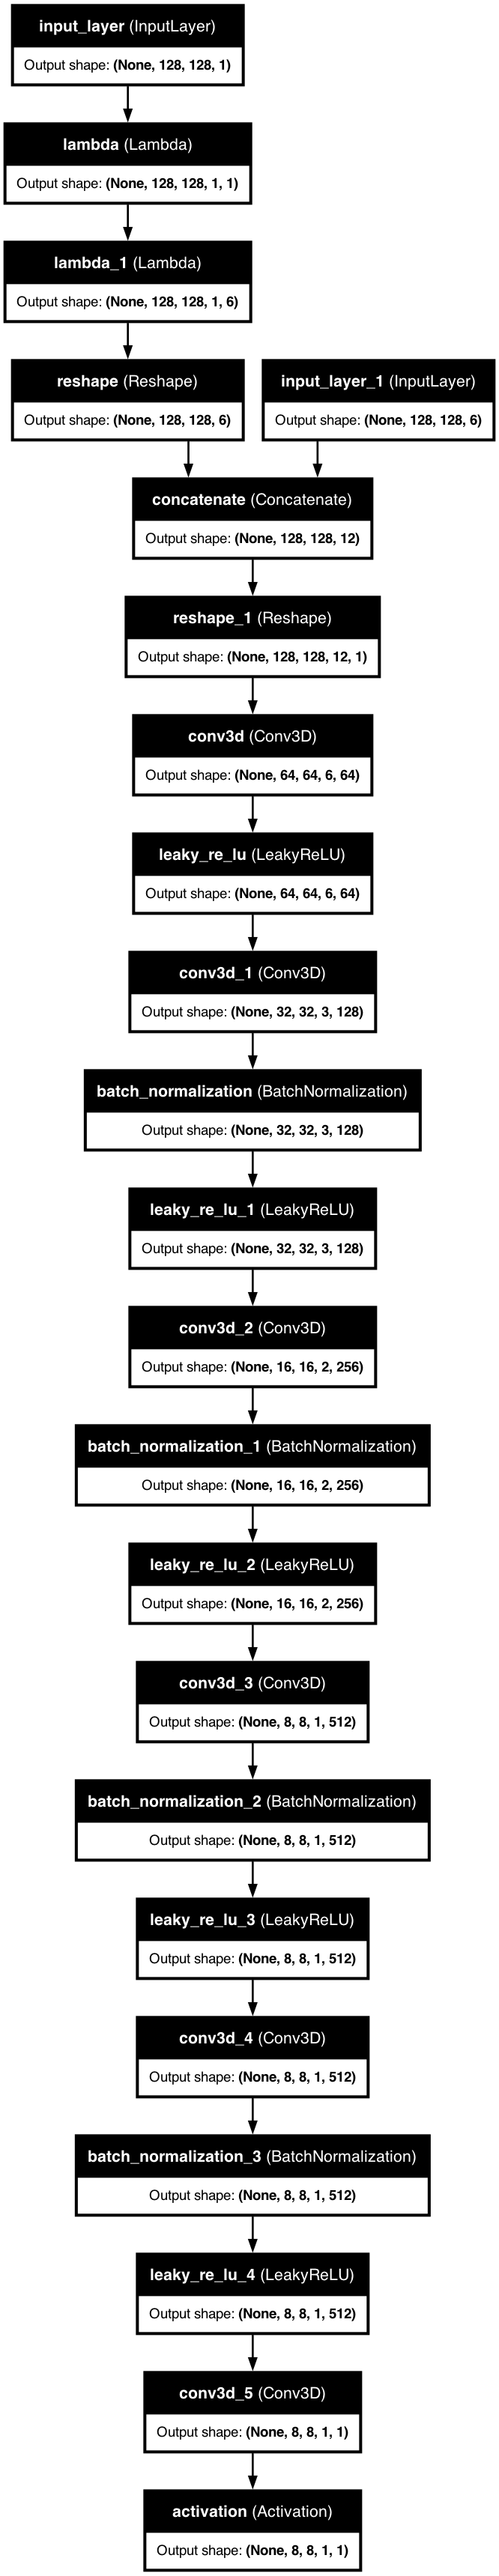

In [8]:
from tensorflow.keras.utils import plot_model
import tensorflow as tf

# After defining your model
tf.keras.utils.plot_model(
    model,
    to_file="discriminator_model_plot.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [9]:
from tensorflow.keras.losses import Loss
from tensorflow.image import ssim
import tensorflow as tf

class SSIMLoss(Loss):
    def __init__(self, max_val=1.0, **kwargs):
        super().__init__(**kwargs)
        self.max_val = max_val

    def call(self, y_true, y_pred):
        return 1 - tf.reduce_mean(ssim(y_true, y_pred, max_val=self.max_val))

    def get_config(self):
        config = super().get_config()
        config.update({"max_val": self.max_val})
        return config

# Register the custom object
tf.keras.utils.get_custom_objects()['SSIMLoss'] = SSIMLoss



# U-Net Generator

In [10]:
# example of defining a u-net encoder-decoder generator model
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
#from keras.utils.vis_utils import plot_model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init, data_format='channels_last')(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init, data_format='channels_last')(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

# define the standalone generator model
def define_generator(image_shape=(128, 128, 1), output_channels = 6):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model: C64-C128-C256-C512-C512-C512-C512-C512
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    #e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init, data_format='channels_last')(e6)
    b = Activation('relu')(b)
    # decoder model: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
    d1 = decoder_block(b, e6, 512)
    d2 = decoder_block(d1, e5, 512)
    d3 = decoder_block(d2, e4, 512)
    #d4 = decoder_block(d3, e4, 512, dropout=False)
    d4 = decoder_block(d3, e3, 256, dropout=False)
    d5 = decoder_block(d4, e2, 128, dropout=False)
    d6 = decoder_block(d5, e1, 64, dropout=False)
    # output
    out_image = Conv2DTranspose(output_channels, (4,4), strides=(2,2), padding='same', kernel_initializer=init, data_format='channels_last')(d6)
    #out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    ssim_loss = SSIMLoss(max_val=1.0)
    model.compile(optimizer='adam', loss=ssim_loss)
    return model

# define image shape
image_shape = (128, 128, 1)

output_channels = 6
# create the model
model = define_generator(image_shape, output_channels)
# summarize the model
model.summary()
# plot the model
#plot_model(model, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)


/Users/anagharamadas/anaconda3/envs/GPU/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      1,088 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │    131,200 │ leaky_re_lu_5[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │    524,544 │ leaky_re_lu_6[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 512) │  2,097,664 │ leaky_re_lu_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 4, 512) │  4,194,816 │ leaky_re_lu_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 512) │      2,048 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_9       │ (None, 4, 4, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 2, 2, 512) │  4,194,816 │ leaky_re_lu_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 512) │      2,048 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_10      │ (None, 2, 2, 512) │          0 │ batch_normalizat

 Total params: 41,845,382 (159.63 MB)

 Trainable params: 41,837,574 (159.60 MB)

 Non-trainable params: 7,808 (30.50 KB)

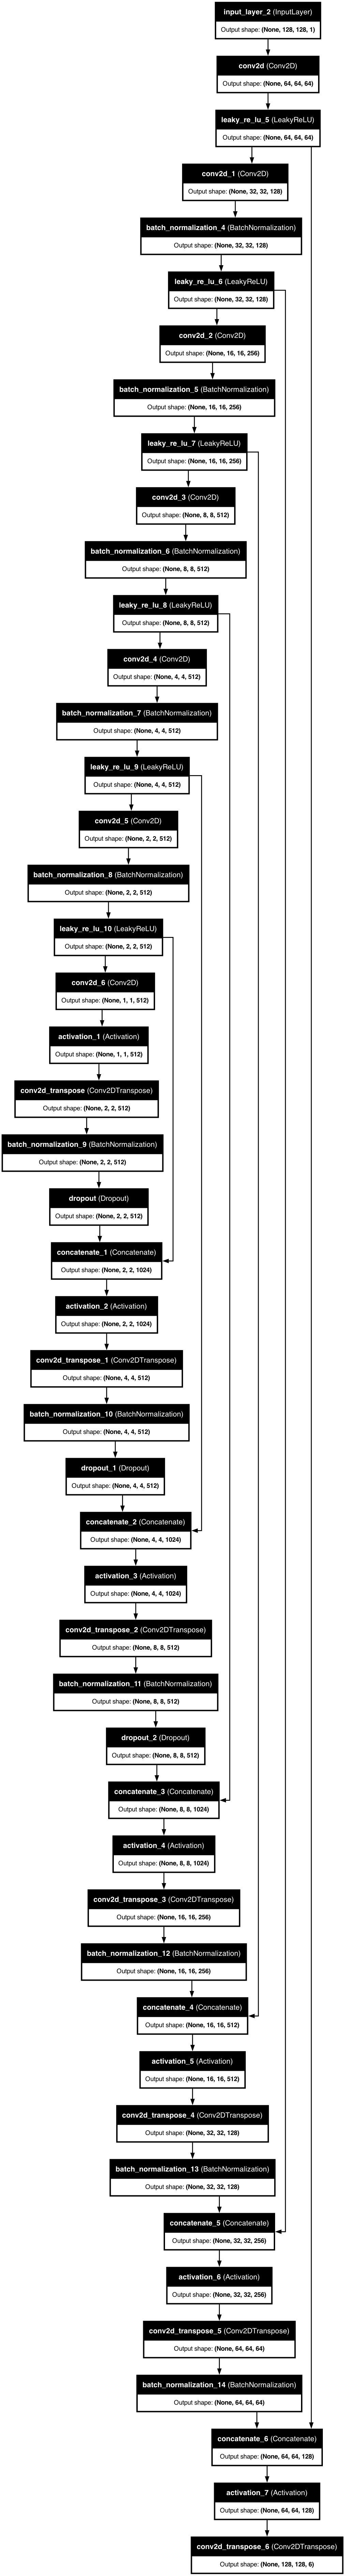

In [11]:
from tensorflow.keras.utils import plot_model
import tensorflow as tf

# After defining your model
tf.keras.utils.plot_model(
    model,
    to_file="generator_model_plot.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96
)

In [12]:

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True
    # define the source image
    in_src = Input(shape=image_shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    ssim_loss = SSIMLoss(max_val=1.0)
    model.compile(loss = ['binary_crossentropy', ssim_loss], optimizer=opt, loss_weights = [1,100])
    return model

In [13]:
custom_objects = {'SSIMLoss': SSIMLoss}

/Users/anagharamadas/anaconda3/envs/GPU/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_7        │ (None, 128, 128,  │ 41,845,382 │ input_layer_6[0]… │
│ (Functional)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_5        │ (None, 8, 8, 1,   │ 27,831,233 │ input_layer_6[0]… │
│ (Functional)        │ 1)                │            │ functional_7[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,676,615 (265.80 MB)

 Trainable params: 69,665,991 (265.75 MB)

 Non-trainable params: 10,624 (41.50 KB)

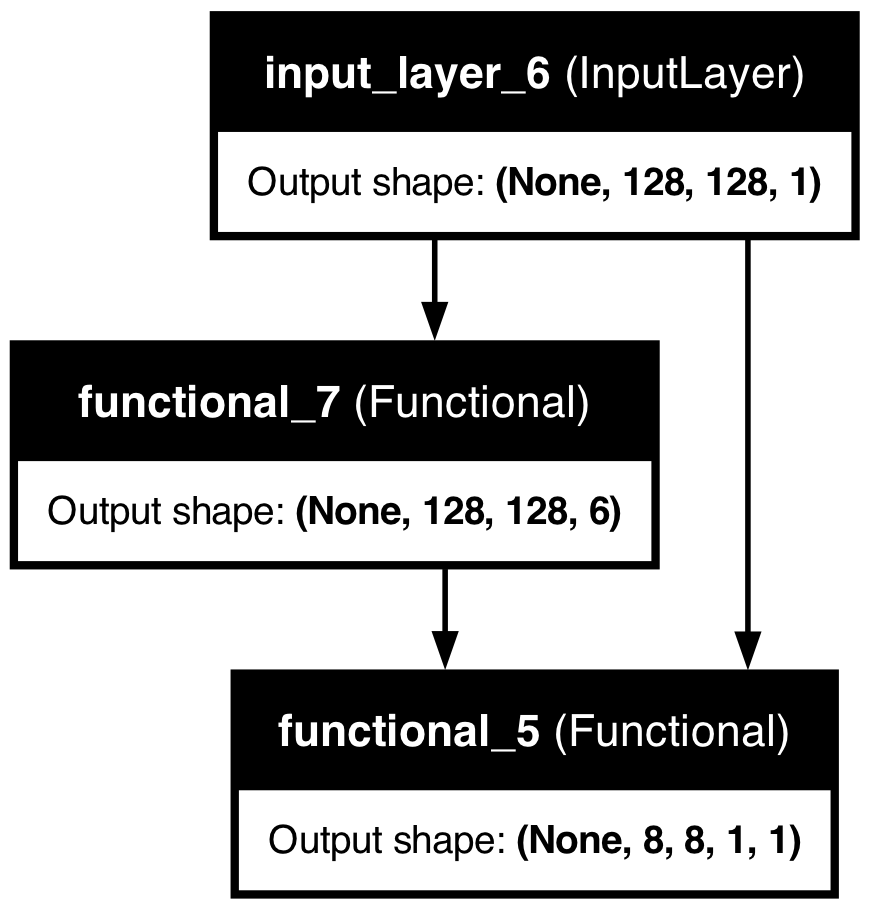

In [14]:
# define image shape
image_shape = (128, 128, 1)
output_shape_3d = (128, 128, 6)
# define the models
d_model = define_discriminator(image_shape, output_shape_3d)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# summarize the model
gan_model.summary()
# plot the model
plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)

# Updating the model weights

In [15]:

import numpy as np
from numpy.random import randint
from numpy import ones
from numpy import zeros
import tensorflow as tf

def split_dataset(dataset):
    # Check the dimensions of the dataset
    if dataset.shape != (2000, 128, 128, 7):
        raise ValueError('Dataset dimensions do not match the expected shape (2000, 128, 128, 7)')
    
    
    # Extract the brightfield images (channel 0)
    brightfield_images = dataset[:, :, :, 0]

    # Extract the fluorescence images (channels 1-6)
    fluorescence_images = dataset[:, :, :, 1:7]

    # Verify the shapes
    print("Brightfield images shape:", brightfield_images.shape)  # Should be (16338, 128, 128)
    print("Fluorescence images shape:", fluorescence_images.shape)  # Should be (16338, 128, 128, 6)

    return brightfield_images, fluorescence_images



In [16]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = split_dataset(dataset)
    print('trainA shape:', trainA.shape)
    print('trainB shape:', trainB.shape)
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [17]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape): 
    # Ensure samples are in channels_last format

    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = np.zeros((len(X),patch_shape, patch_shape, 1))
    return X, y

In [18]:
"""
def check_dataset_format(file_path):
    with h5py.File(file_path, 'r') as f:
        # Access the dataset
        images_dataset = f['images']
        num_images, height, width, num_channels = images_dataset.shape
        print(f"Dataset shape: {images_dataset.shape}")
        print(f"Dataset contains {num_images} images with {num_channels} channels each, of size {height}x{width}.")
        
        # Verify the datatype
        datatype = images_dataset.dtype
        print(f"Image datatype: {datatype}")

        # Check if the dataset follows NHWC format
        if len(images_dataset.shape) == 4 and images_dataset.shape[1] == height and images_dataset.shape[2] == width and images_dataset.shape[3] == num_channels:
            print("Dataset follows NHWC format.")
        else:
            print("Dataset does not follow NHWC format.")
        
        return images_dataset

# Usage
file_path = 'transposed_normalized_images.h5'
images_dataset = check_dataset_format(file_path)

"""

'\ndef check_dataset_format(file_path):\n    with h5py.File(file_path, \'r\') as f:\n        # Access the dataset\n        images_dataset = f[\'images\']\n        num_images, height, width, num_channels = images_dataset.shape\n        print(f"Dataset shape: {images_dataset.shape}")\n        print(f"Dataset contains {num_images} images with {num_channels} channels each, of size {height}x{width}.")\n        \n        # Verify the datatype\n        datatype = images_dataset.dtype\n        print(f"Image datatype: {datatype}")\n\n        # Check if the dataset follows NHWC format\n        if len(images_dataset.shape) == 4 and images_dataset.shape[1] == height and images_dataset.shape[2] == width and images_dataset.shape[3] == num_channels:\n            print("Dataset follows NHWC format.")\n        else:\n            print("Dataset does not follow NHWC format.")\n        \n        return images_dataset\n\n# Usage\nfile_path = \'transposed_normalized_images.h5\'\nimages_dataset = check_datas

In [19]:
n_batch = 1000
n_patch = 8
#print(images_dataset.shape)
#file_path = 'transposed_normalized_images.h5'


#data = np.load('fluor_images_transposed_asnumpy.npz')


#print(data.files)
#data = data['array']

"""
# Open the file and keep it open
f = h5py.File(file_path, 'r')
images_dataset = f['images']
import numpy as np
"""

# Number of images to extract
#num_images_to_extract = 2000

# Randomly select 2000 indices from the dataset
#indices = np.arange(2000)

# Extract the selected images
#extracted_images = data[:num_images_to_extract]
#images_dataset = extracted_images

# Check the shape of the extracted images
#print("Extracted images shape:", extracted_images.shape)
#print("Extracted images shape:", images_dataset.shape)

#images_dataset = normalized_dataset(images_dataset)


# select a batch of real samples


"\n# Open the file and keep it open\nf = h5py.File(file_path, 'r')\nimages_dataset = f['images']\nimport numpy as np\n"

In [20]:
def brightfield_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 0]
        if(np.min(img) <minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)

    return [minimum_value, maximum_value] 

def channel1_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 1]
        if(np.min(img) <minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)
    return [minimum_value, maximum_value]


def channel2_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 2]
        if(np.min(img) < minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)

    return [minimum_value, maximum_value]

def channel3_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 3]
        if(np.min(img) < minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)
    return [minimum_value, maximum_value]

def channel4_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 4]
        if(np.min(img) < minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)
    return [minimum_value, maximum_value]

def channel5_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 5]
        if(np.min(img) < minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)
    return [minimum_value, maximum_value]

def channel6_images(minimum_value, maximum_value, images_dataset):
    for i in range(images_dataset.shape[0]):
        img = images_dataset[i, :, :, 6]
        if(np.min(img) < minimum_value):
            minimum_value = np.min(img)
        if(np.max(img) > maximum_value):
            maximum_value = np.max(img)
    return [minimum_value, maximum_value]

def normalization_process(image, min_val, max_val):
    image = (((image.astype(np.float32) - min_val) / (max_val - min_val)) * 65535).astype(np.float32)
    image = (image.astype(np.float32)/ 65535).astype(np.float32)
    return image

In [21]:
def normalization_of_images(images_dataset):
    
    minimum_value_bf =  np.min(images_dataset[:, :, :, 0])  
    maximum_value_bf = np.max(images_dataset[:, :, :, 0])
    
    minimum_value_1 =  np.min(images_dataset[:, :, :, 1])  
    maximum_value_1 = np.max(images_dataset[:, :, :, 1])
    
    minimum_value_2 =  np.min(images_dataset[:, :, :, 2])  
    maximum_value_2 = np.max(images_dataset[:, :, :, 2])
    
    minimum_value_3 =  np.min(images_dataset[:, :, :, 3])  
    maximum_value_3 = np.max(images_dataset[:, :, :, 3])
    
    minimum_value_4 =  np.min(images_dataset[:, :, :, 4])  
    maximum_value_4 = np.max(images_dataset[:, :, :, 4])
    
    minimum_value_5 =  np.min(images_dataset[:, :, :, 5])  
    maximum_value_5 = np.max(images_dataset[:, :, :, 5])

    minimum_value_6 =  np.min(images_dataset[:, :, :, 6])  
    maximum_value_6 = np.max(images_dataset[:, :, :, 6])
    
    
    minimum_value_bf, maximum_value_bf =  brightfield_images(minimum_value_bf, maximum_value_bf, images_dataset) 
    minimum_value_1, maximum_value_1 =  channel1_images(minimum_value_1, maximum_value_1, images_dataset) 
    minimum_value_2, maximum_value_2 =  channel2_images(minimum_value_2, maximum_value_2, images_dataset) 
    minimum_value_3, maximum_value_3 =  channel3_images(minimum_value_3, maximum_value_3, images_dataset) 
    minimum_value_4, maximum_value_4 =  channel4_images(minimum_value_4, maximum_value_4, images_dataset) 
    minimum_value_5, maximum_value_5 =  channel5_images(minimum_value_5, maximum_value_5, images_dataset) 
    minimum_value_6, maximum_value_6 =  channel6_images(minimum_value_6, maximum_value_6, images_dataset) 
    
   
    
    
    for i in range(images_dataset.shape[0]):
        for j in range(images_dataset.shape[-1]):
            if(j==0):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_bf, maximum_value_bf)
                images_dataset[i, :, :, j] = temp_image
                
            if(j==1):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_1)
                images_dataset[i, :, :, j] = temp_image
                
            if(j==2):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_2)
                images_dataset[i, :, :, j] = temp_image
            
            if(j==3):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_3)
                images_dataset[i, :, :, j] = temp_image
                
            if(j==4):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_4)
                images_dataset[i, :, :, j] = temp_image
                
            if(j==5):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_5)
                images_dataset[i, :, :, j] = temp_image
                
            if(j==6):
                image = images_dataset[i, :, :, j]
                temp_image = normalization_process(image, minimum_value_1, maximum_value_6)
                images_dataset[i, :, :, j] = temp_image
            
        

    
    
                
    print("minimum value in channel of brightfield images = ", minimum_value_bf)
    print("maximum value in channel of brightfield images = ", maximum_value_bf)
    print() 
    
    print("minimum value in channel 1 of images = ", minimum_value_1)
    print("maximum value in channel 1 of images = ", maximum_value_1)
    print() 
    
    print("minimum value in channel 2 of images = ", minimum_value_2)
    print("maximum value in channel 2 of images = ", maximum_value_2)
    print() 
    
    print("minimum value in channel 3 of images = ", minimum_value_3)
    print("maximum value in channel 3 of images = ", maximum_value_3)
    print() 
    
    print("minimum value in channel 4 of images = ", minimum_value_4)
    print("maximum value in channel 4 of images = ", maximum_value_4)
    print() 
    
    print("minimum value in channel 5 of images = ", minimum_value_5)
    print("maximum value in channel 5 of images = ", maximum_value_5)
    print() 
    
    print("minimum value in channel 6 of images = ", minimum_value_6)
    print("maximum value in channel 6 of images = ", maximum_value_6)
    print()
    
    print("shape of normalized images dataset = ", images_dataset.shape)
    #print("maximum value in channel 6 of images = ", maximum_value_6)
    print()
    
    return images_dataset
    

In [22]:
#images_dataset = normalization_of_images(images_dataset)


In [23]:
#print(images_dataset.dtype)

In [24]:
def min_and_max_images(images_dataset):    
    minimum_value_bf =  np.min(images_dataset[:, :, :, 0])  
    maximum_value_bf = np.max(images_dataset[:, :, :, 0])

    minimum_value_1 =  np.min(images_dataset[:, :, :, 1])  
    maximum_value_1 = np.max(images_dataset[:, :, :, 1])

    minimum_value_2 =  np.min(images_dataset[:, :, :, 2])  
    maximum_value_2 = np.max(images_dataset[:, :, :, 2])

    minimum_value_3 =  np.min(images_dataset[:, :, :, 3])  
    maximum_value_3 = np.max(images_dataset[:, :, :, 3])

    minimum_value_4 =  np.min(images_dataset[:, :, :, 4])  
    maximum_value_4 = np.max(images_dataset[:, :, :, 4])

    minimum_value_5 =  np.min(images_dataset[:, :, :, 5])  
    maximum_value_5 = np.max(images_dataset[:, :, :, 5])

    minimum_value_6 =  np.min(images_dataset[:, :, :, 6])  
    maximum_value_6 = np.max(images_dataset[:, :, :, 6])
    
                    
    print("minimum value in channel of brightfield images = ", minimum_value_bf)
    print("maximum value in channel of brightfield images = ", maximum_value_bf)
    print() 
    
    print("minimum value in channel 1 of images = ", minimum_value_1)
    print("maximum value in channel 1 of images = ", maximum_value_1)
    print() 
    
    print("minimum value in channel 2 of images = ", minimum_value_2)
    print("maximum value in channel 2 of images = ", maximum_value_2)
    print() 
    
    print("minimum value in channel 3 of images = ", minimum_value_3)
    print("maximum value in channel 3 of images = ", maximum_value_3)
    print() 
    
    print("minimum value in channel 4 of images = ", minimum_value_4)
    print("maximum value in channel 4 of images = ", maximum_value_4)
    print() 
    
    print("minimum value in channel 5 of images = ", minimum_value_5)
    print("maximum value in channel 5 of images = ", maximum_value_5)
    print() 
    
    print("minimum value in channel 6 of images = ", minimum_value_6)
    print("maximum value in channel 6 of images = ", maximum_value_6)
    print()
    
    print("shape of normalized images dataset = ", images_dataset.shape)

In [25]:
#min_and_max_images(images_dataset)

In [26]:
[X_realA, X_realB], y_real = generate_real_samples(images_dataset, n_batch, n_patch)
print(X_realA.shape)
print(X_realB.shape)
print(y_real.shape)

NameError: name 'images_dataset' is not defined

In [27]:
def display_image(image, channel=0):
    plt.imshow(image[:,:,channel], cmap='inferno', vmin=0, vmax=1)
    plt.axis('off')
    plt.show()

# Display the first image, first channel
display_image(images_dataset[0])

NameError: name 'images_dataset' is not defined

In [28]:
...

# generate a batch of fake samples
X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)


NameError: name 'X_realA' is not defined

In [29]:
plt.figure(figsize=(20, 20))

for j in range(5):
    img = X_fakeB[0,:, :, j]
    plt.subplot(1, 7, 0 * 7 + j + 1)
    plt.imshow(img, cmap='inferno')
    plt.title(f'Image {1}, Channel {j}')
    plt.axis('off')
    print(img.min(), img.max())

plt.show()


NameError: name 'X_fakeB' is not defined

<Figure size 2000x2000 with 0 Axes>

In [30]:
print("X_realA shape:", X_realA.shape)
print("X_realB shape:", X_realB.shape)
print("y_real shape:", y_real.shape)
print("X_fakeB shape:", X_fakeB.shape)
print("y_fake shape:", y_fake.shape)

NameError: name 'X_realA' is not defined

In [31]:
# Get the discriminator's output for the generated images
disc_generated_output = d_model([X_realA, X_fakeB])


NameError: name 'X_realA' is not defined

In [32]:

# Example model compilation for multiple outputs
d_model.compile(optimizer='Adam', loss='binary_crossentropy')
d_model.trainable = True
# update discriminator for real samples
#d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
# update discriminator for generated samples
#d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)


In [33]:
# Assuming you have already defined and created the gan_model
# Define the optimizer and compile the GAN model
from keras.optimizers import SGD
 
opt = Adam(learning_rate=0.0002)
ssim_loss = SSIMLoss(max_val=1.0)
gan_model.compile(loss=['binary_crossentropy', ssim_loss], optimizer=opt, loss_weights=[1, 100])

X_realA = X_realA.astype(np.float32)
X_realB = X_realB.astype(np.float32)

X_realA = (X_realA - 127.5) / 127.5
X_realB = (X_realB - 127.5) / 127.5

# Now you can call train_on_batch
#g_loss = gan_model.train_on_batch(X_realA, [y_real, X_realB])
#print(f"Generator loss on fake samples: {g_loss}")

NameError: name 'X_realA' is not defined

In [34]:
import os
from tensorflow.keras.callbacks import Callback
#from skimage.metrics import structural_similarity as ssim
from tensorflow.image import ssim

class CustomModelCheckpoint(Callback):
    def __init__(self, g_model, d_model, gan_model, filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1):
        super(CustomModelCheckpoint, self).__init__()
        self.g_model = g_model
        self.d_model = d_model
        self.gan_model = gan_model
        self.filepath = filepath
        self.monitor = monitor
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.save_weights_only = save_weights_only
        self.period = period
        self.epochs_since_last_save = 0
        self.best = float('inf') if mode == 'min' else float('-inf')
        self.monitor_op = np.less if mode == 'min' else np.greater
        
        if mode not in ['auto', 'min', 'max']:
            mode = 'auto'
        if mode == 'min':
            self.monitor_op = np.less
            self.best = float('inf')
        elif mode == 'max':
            self.monitor_op = np.greater
            self.best = float('-inf')
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
                self.best = float('-inf')
            else:
                self.monitor_op = np.less
                self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            filepath = self.filepath.format(epoch=epoch + 1, **logs)
            if self.save_best_only:
                current = logs.get(self.monitor)
                if current is None:
                    warnings.warn(f'Can save best model only with {self.monitor} available, skipping.', RuntimeWarning)
                else:
                    if self.monitor_op(current, self.best):
                        if self.verbose > 0:
                            print(f'\nEpoch {epoch + 1}: {self.monitor} improved from {self.best:.5f} to {current:.5f}, saving model to {filepath}')
                        self.best = current
                        self._save_model(filepath, overwrite=True)
                    else:
                        if self.verbose > 0:
                            print(f'\nEpoch {epoch + 1}: {self.monitor} did not improve from {self.best:.5f}')
            else:
                if self.verbose > 0:
                    print(f'\nEpoch {epoch + 1}: saving model to {filepath}')
                self._save_model(filepath, overwrite=True)


    def _save_model(self, filepath):
        if self.save_weights_only:
            self.g_model.save_weights(filepath + '_generator.h5')
            self.d_model.save_weights(filepath + '_discriminator.h5')
            self.gan_model.save_weights(filepath + '_gan.h5')
        else:
            self.g_model.save(filepath + '_generator.keras')
            self.d_model.save(filepath + '_discriminator.keras')
            self.gan_model.save(filepath + '_gan.keras')


In [35]:
import os
import shutil


# Clear previous checkpoints
checkpoint_dir = 'checkpoints'
if os.path.exists(checkpoint_dir):
    print("checkpoint directory exists")
    shutil.rmtree(checkpoint_dir)
os.makedirs(checkpoint_dir)


checkpoint directory exists


In [36]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import glob

checkpoint_dir = 'checkpoints'

os.makedirs(checkpoint_dir, exist_ok=True)

In [37]:
latest_checkpoint = None

# Find the latest checkpoint file for each model
generator_checkpoints = glob.glob(os.path.join(checkpoint_dir, '*_generator.keras'))
discriminator_checkpoints = glob.glob(os.path.join(checkpoint_dir, '*_discriminator.keras'))
gan_checkpoints = glob.glob(os.path.join(checkpoint_dir, '*_gan.keras'))

if generator_checkpoints and discriminator_checkpoints and gan_checkpoints:
    latest_generator = max(generator_checkpoints, key=os.path.getctime)
    latest_discriminator = max(discriminator_checkpoints, key=os.path.getctime)
    latest_gan = max(gan_checkpoints, key=os.path.getctime)
    
    print(f"Found checkpoints:\nGenerator: {latest_generator}\nDiscriminator: {latest_discriminator}\nGAN: {latest_gan}")
    latest_checkpoint = True
else:
    print("No complete set of checkpoints found. Starting from scratch.")
    latest_checkpoint = None

No complete set of checkpoints found. Starting from scratch.


In [38]:
#latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
"""
starting_epoch = 0
if latest_checkpoint:
    print(f"Found checkpoint: {latest_checkpoint}")
    epoch_str = os.path.basename(latest_checkpoint).split('_')[2]
    starting_epoch = int(epoch_str)
    print(f"Resuming from epoch {starting_epoch}")
else:
    print("No checkpoints found. Starting from scratch.")
    starting_epoch = 0
"""

'\nstarting_epoch = 0\nif latest_checkpoint:\n    print(f"Found checkpoint: {latest_checkpoint}")\n    epoch_str = os.path.basename(latest_checkpoint).split(\'_\')[2]\n    starting_epoch = int(epoch_str)\n    print(f"Resuming from epoch {starting_epoch}")\nelse:\n    print("No checkpoints found. Starting from scratch.")\n    starting_epoch = 0\n'

In [39]:
input_shape_2d = (128, 128, 1)
output_shape_3d = (128, 128, 6)
image_shape = (128, 128, 1)


In [40]:
d_model = define_discriminator(input_shape_2d, output_shape_3d)
g_model = define_generator(image_shape)
gan_model = define_gan(g_model, d_model, image_shape)



/Users/anagharamadas/anaconda3/envs/GPU/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [41]:
import os
import tensorflow as tf

starting_epoch = 0
if latest_checkpoint:
    print("Loading weights from checkpoints...")
    try:
        # Load weights for each model separately
        g_model.load_weights(latest_generator)
        d_model.load_weights(latest_discriminator)
        gan_model.load_weights(latest_gan)
        epoch_str = os.path.basename(latest_generator).split('_')[2]
        starting_epoch = int(epoch_str)
        print(f"Resuming from epoch {starting_epoch}")
        print("Weights loaded successfully.")
    except Exception as e:
        print(f"Error loading weights: {str(e)}")
        print("Initializing models with random weights.")
        # If loading fails, we'll start with fresh models
        g_model = define_generator(image_shape)
        d_model = define_discriminator(input_shape_2d, output_shape_3d)
        gan_model = define_gan(g_model, d_model, image_shape)

# Create the custom checkpoint callback
custom_checkpoint = CustomModelCheckpoint(
    g_model=g_model,
    d_model=d_model,
    gan_model=gan_model,
    filepath=os.path.join(checkpoint_dir, 'model_checkpoint_{epoch:02d}_{val_loss:.2f}'),
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    period=1
)


In [42]:
"""
starting_epoch = 0
if latest_checkpoint:
    # Extract the epoch number from the checkpoint file name
    starting_epoch = int(latest_checkpoint.split('-')[-1].split('.')[0])
"""


"\nstarting_epoch = 0\nif latest_checkpoint:\n    # Extract the epoch number from the checkpoint file name\n    starting_epoch = int(latest_checkpoint.split('-')[-1].split('.')[0])\n"

In [43]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_path, batch_size, patch_shape, generator_model):
        
        self.file_path = file_path
        self.batch_size = batch_size
        self.patch_shape = patch_shape
        
        self.data = np.load(file_path)['array']
        self.data = self.data[:2000]
        print(self.data.shape)
        self.data = normalization_of_images(self.data)

        self.indices = np.arange(self.data.shape[0])
        self.generator_model = generator_model
        self.trainA, self.trainB = split_dataset(self.data)
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.trainA) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Generate data
        X_realA, X_realB, y_real, X_fakeB, y_fake = self.__data_generation(indexes)
        return [X_realA, X_realB], [y_real, X_fakeB, y_fake]


    def on_epoch_end(self):
        self.indexes = np.arange(len(self.trainA))
        np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        # Generate real samples
        X_realA, X_realB = self.trainA[indexes], self.trainB[indexes]
        y_real = np.ones((self.batch_size, self.patch_shape, self.patch_shape, 1))
        
        # Generate fake samples
        X_fakeB = self.generator_model.predict(X_realA)
        y_fake = np.zeros((self.batch_size, self.patch_shape, self.patch_shape, 1))
        
    
        
        return X_realA, X_realB, y_real, X_fakeB, y_fake


In [44]:
"""
# Define loss functions
def mae_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))
    """

'\n# Define loss functions\ndef mae_loss(y_true, y_pred):\n    return tf.reduce_mean(tf.abs(y_true - y_pred))\n    '

In [45]:
import tensorflow as tf

def calculate_ssim_loss(real_images, generated_images):
    # Ensure the images are in the range [0, 1]
    real_images = tf.convert_to_tensor(real_images, dtype=tf.float32)
    generated_images = tf.convert_to_tensor(generated_images, dtype=tf.float32)
    
    # Calculate SSIM scores
    ssim_scores = tf.image.ssim(real_images, generated_images, max_val=1.0)
    
    # Calculate mean SSIM score
    mean_ssim = tf.reduce_mean(ssim_scores)
    
    # Convert SSIM to loss (1 - SSIM)
    ssim_loss = 1 - mean_ssim
    
    return ssim_loss


In [46]:
"""
def combined_mae_ssim_loss(y_true, y_pred, mae_weight=0.5, ssim_weight=0.5):
    mae = mae_loss(y_true, y_pred)
    ssim = ssim_loss(y_true, y_pred)
    return mae_weight * mae + ssim_weight * ssim

# Compile the generator with the custom loss function
g_model.compile(optimizer='adam', loss=combined_mae_ssim_loss)
"""

"\ndef combined_mae_ssim_loss(y_true, y_pred, mae_weight=0.5, ssim_weight=0.5):\n    mae = mae_loss(y_true, y_pred)\n    ssim = ssim_loss(y_true, y_pred)\n    return mae_weight * mae + ssim_weight * ssim\n\n# Compile the generator with the custom loss function\ng_model.compile(optimizer='adam', loss=combined_mae_ssim_loss)\n"

In [47]:
# Assuming you have already defined and created the generator model (g_model)
batch_size = 32
patch_shape = 8  # Example patch shape, adjust as necessary
  # Example dataset, replace with actual data
epochs = 25

data_gen = DataGenerator('fluor_images_transposed_asnumpy.npz', batch_size, patch_shape, g_model)


# Training loop
for epoch in range(epochs):
    for batch in range(len(data_gen)):
        [X_realA, X_realB], [y_real, X_fakeB, y_fake] = data_gen[batch]
        
        # Train the discriminator
        d_loss_real = d_model.train_on_batch([X_realA, X_realB], y_real)
        d_loss_fake = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Train the generator
        g_loss = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        
        # Calculate SSIM loss
        #mae_loss = 
        ssim_loss = calculate_ssim_loss(X_realB, X_fakeB)
        
        print(f'Epoch {epoch+1}, Batch: {batch+1}, SSIM Loss: {ssim_loss}')
        print(f"Epoch: {epoch+1}, Batch: {batch+1}, D Loss Real: {d_loss_real}, D Loss Fake: {d_loss_fake}, G Loss: {g_loss}")
      
        
    custom_checkpoint.on_epoch_end(epoch, logs={'val_loss': g_loss})
    # Clear the Keras session
    tf.keras.backend.clear_session()

# Ensure to call on_train_end at the end of training
custom_checkpoint.on_train_end(logs={})

(2000, 128, 128, 7)
minimum value in channel of brightfield images =  1072.0
maximum value in channel of brightfield images =  3368.0

minimum value in channel 1 of images =  38.0
maximum value in channel 1 of images =  788.0

minimum value in channel 2 of images =  45.0
maximum value in channel 2 of images =  956.0

minimum value in channel 3 of images =  34.0
maximum value in channel 3 of images =  784.0

minimum value in channel 4 of images =  28.0
maximum value in channel 4 of images =  595.0

minimum value in channel 5 of images =  63.0
maximum value in channel 5 of images =  702.0

minimum value in channel 6 of images =  13.0
maximum value in channel 6 of images =  317.0

shape of normalized images dataset =  (2000, 128, 128, 7)

Brightfield images shape: (2000, 128, 128)
Fluorescence images shape: (2000, 128, 128, 6)


2024-08-07 01:56:00.183458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
Epoch 1, Batch: 1, SSIM Loss: 0.8865629434585571
Epoch: 1, Batch: 1, D Loss Real: 1.2515835762023926, D Loss Fake: 2.0979995727539062, G Loss: 101.0090103149414
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 1, Batch: 2, SSIM Loss: 0.8469732999801636
Epoch: 1, Batch: 2, D Loss Real: 1.5592185258865356, D Loss Fake: 2.005303382873535, G Loss: 100.22743225097656
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 1, Batch: 3, SSIM Loss: 0.8191152215003967
Epoch: 1, Batch: 3, D Loss Real: 1.6456525325775146, D Loss Fake: 1.8456281423568726, G Loss: 99.66527557373047
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Epoch 1, Batch: 4, SSIM Loss: 0.8025559782981873
Epoch: 1, Batch: 4, D Loss Real: 1.6557859182357788, D Loss Fake: 1.6975164413452148, G Loss: 98.51992797851562
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Epoch 1, Batch: 5, SSIM Loss: 0.7780003547668457
Epoch: 1, Batch: 5, D Loss Real: 1.5481263399124146, D Loss Fake: 1.5471137762069702, G Loss: 96.23304748535156
1/1 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1, Batch: 30, SSIM Loss: 0.33646178245544434
Epoch: 1, Batch: 30, D Loss Real: 0.5589314103126526, D Loss Fake: 0.5503674745559692, G Loss: 46.77470779418945
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 1, Batch: 31, SSIM Loss: 0.2843855023384094
Epoch: 1, Batch: 31, D Loss Real: 0.5417183637619019, D Loss Fake: 0.5337033867835999, G Loss: 45.965248107910156
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Epoch 1, Batch: 32, SSIM Loss: 0.29805660247802734
Epoch: 1, Batch: 32, D Loss Real: 0.5255731344223022, D Loss Fake: 0.5181183815002441, G Loss: 45.130096435546875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1, Batch: 33, SSIM Loss: 0.31647026538848877
Epoch: 1, Batch: 33, D Loss Real: 0.5105160474777222, D Loss Fake: 0.5036765336990356, G Loss: 44.37489700317383
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Epoch 1, Batch: 34, SSIM Loss: 0.2822767496109009
Epoch: 1, Batch: 34, D Loss Real: 0.4964601397514343, D Loss Fake: 0.4901811480522156, G Loss: 43.6384

TypeError: CustomModelCheckpoint._save_model() got an unexpected keyword argument 'overwrite'

In [ ]:
plt.figure(figsize=(20, 20))

for j in range(X_realA.shape[-1]):
    img = X_realA[0,:, :, j]
    plt.subplot(1, 7, 0 * 7 + j + 1)
    plt.imshow(img, cmap='inferno')
    plt.title(f'Image {1}, Channel {j}')
    plt.axis('off')

plt.show()


In [ ]:

plt.figure(figsize=(20, 20))

for j in range(X_fakeB.shape[-1]):
    img = X_fakeB[0,:, :, j]
    plt.subplot(1, 7, 0 * 7 + j + 1)
    plt.imshow(img, cmap='inferno')
    plt.title(f'Image {1}, Channel {j}')
    plt.axis('off')
    print(img.min(), img.max())

plt.show()
